# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2

split = int(validation_split * data_size)
indices = list(range(data_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)

# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Epoch: ", epoch)
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    batch_accuracy = 0

    for i_step, (x, y) in enumerate(val_loader):
        prediction = model(x)
        predicted_output = torch.argmax(prediction, 1)

        batch_accuracy += torch.sum(y == predicted_output) / y.shape[0]
    
    return batch_accuracy / i_step

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Epoch:  0
Average loss: 1.805708, Train accuracy: 0.423711, Val accuracy: 0.565724
Epoch:  1
Average loss: 1.450995, Train accuracy: 0.587756, Val accuracy: 0.603581
Epoch:  2
Average loss: 1.377614, Train accuracy: 0.620704, Val accuracy: 0.635598


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [7]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 10)
    )

nn_model.type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Epoch:  0
Average loss: 2.195595, Train accuracy: 0.206293, Val accuracy: 0.235113
Epoch:  1
Average loss: 2.002725, Train accuracy: 0.282974, Val accuracy: 0.324883
Epoch:  2
Average loss: 1.809215, Train accuracy: 0.360407, Val accuracy: 0.390793
Epoch:  3
Average loss: 1.718929, Train accuracy: 0.406580, Val accuracy: 0.427880
Epoch:  4
Average loss: 1.686270, Train accuracy: 0.425963, Val accuracy: 0.434270


Добавьте слой с Batch Normalization

In [8]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

print("batch normalization before ReLU")

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 128),
    torch.nn.BatchNorm1d(128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 64),
    torch.nn.BatchNorm1d(64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 10)
    )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

print("batch normalization after ReLU")

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 128),
    nn.ReLU(inplace=True),
    torch.nn.BatchNorm1d(128),
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    torch.nn.BatchNorm1d(64),
    nn.Linear(64, 10)
    )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

batch normalization before ReLU
Epoch:  0
Average loss: 2.052368, Train accuracy: 0.323004, Val accuracy: 0.431563
Epoch:  1
Average loss: 1.789555, Train accuracy: 0.461762, Val accuracy: 0.514583
Epoch:  2
Average loss: 1.662340, Train accuracy: 0.529946, Val accuracy: 0.578460
Epoch:  3
Average loss: 1.583906, Train accuracy: 0.573303, Val accuracy: 0.601206
Epoch:  4
Average loss: 1.528731, Train accuracy: 0.599836, Val accuracy: 0.632919
batch normalization after ReLU
Epoch:  0
Average loss: 1.930227, Train accuracy: 0.380524, Val accuracy: 0.544543
Epoch:  1
Average loss: 1.535188, Train accuracy: 0.588455, Val accuracy: 0.634050
Epoch:  2
Average loss: 1.366007, Train accuracy: 0.647033, Val accuracy: 0.668133
Epoch:  3
Average loss: 1.269308, Train accuracy: 0.672969, Val accuracy: 0.688703
Epoch:  4
Average loss: 1.208554, Train accuracy: 0.691704, Val accuracy: 0.704557


Добавьте уменьшение скорости обучения по ходу тренировки.

In [9]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        scheduler.step()
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Epoch: ", epoch)
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history


nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 128),
    nn.ReLU(inplace=True),
    torch.nn.BatchNorm1d(128),
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    torch.nn.BatchNorm1d(64),
    nn.Linear(64, 10)
    )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma= .2)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 5)

Epoch:  0
Average loss: 1.931979, Train accuracy: 0.380354, Val accuracy: 0.562811
Epoch:  1
Average loss: 1.510751, Train accuracy: 0.596355, Val accuracy: 0.645494
Epoch:  2
Average loss: 1.352991, Train accuracy: 0.659386, Val accuracy: 0.667293
Epoch:  3
Average loss: 1.316647, Train accuracy: 0.672986, Val accuracy: 0.683460
Epoch:  4
Average loss: 1.290792, Train accuracy: 0.681603, Val accuracy: 0.689782


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [11]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    sampler = SubsetSampler(val_indices)
    val_data = torch.utils.data.DataLoader(data_train, sampler=sampler)
    
    predictions = []
    ground_truth = []
    for x,y in val_data:
        pred = nn_model(x)
        predictions.append(torch.argmax(pred))
        ground_truth.append(y)
    
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))
# assert ground_truth != predictions

C:\Users\lena\AppData\Local\Temp\ipykernel_7380\2157268204.py:50: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  assert np.any(np.not_equal(gt, predictions))
C:\Users\lena\AppData\Local\Temp\ipykernel_7380\2157268204.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  assert np.any(np.not_equal(gt, predictions))


## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

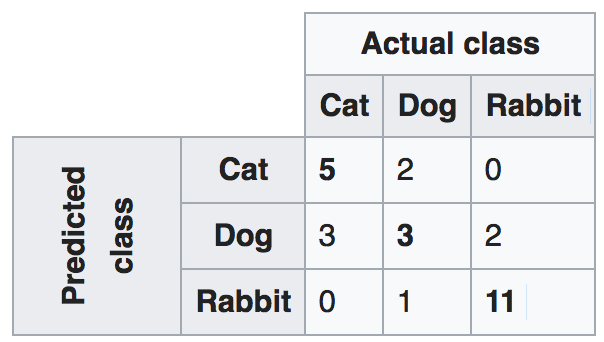

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

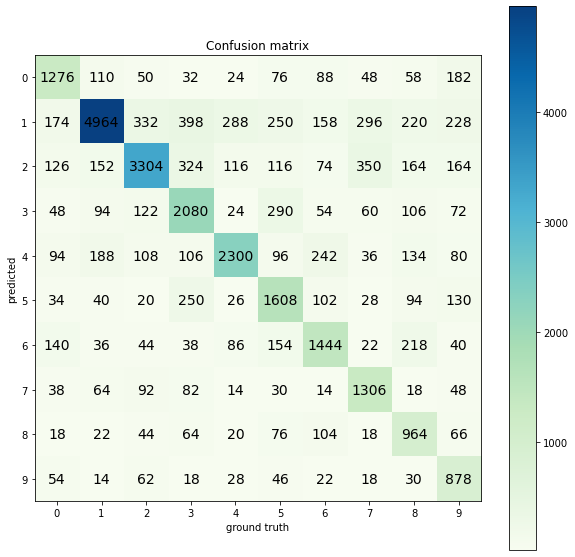

In [12]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """

    confusion_matrix = np.zeros((10,10), int)
    for i in range(len(predictions)) : confusion_matrix[predictions[i], gt[i]] += 1 
    
    # TODO: Implement filling the prediction matrix
    for i in range(len(predictions)) : confusion_matrix[predictions[i], gt[i]] += 1 
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

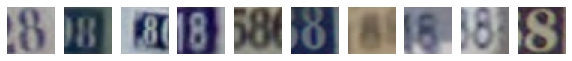

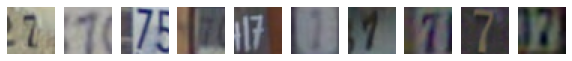

In [13]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    predicted_indexes = np.where(torch.asarray(predictions)==predicted_class)[0]
    gt_indexes = np.where(torch.asarray(gt)==gt_class)[0]
    predicted_gt_indices = np.intersect1d(predicted_indexes,gt_indexes)
    
    indices = np.array(val_indices)[predicted_gt_indices]
    
    visualize_images(indices, data_train_images)
    

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [ ]:
# Experiment here!

In [23]:
expriment_model = nn.Sequential(
    Flattener(),
    
    nn.Linear(32*32*3, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    
    nn.Linear(64, 10),
#     nn.ReLU(),
#     nn.BatchNorm1d(64),
    
#     nn.Linear(64, 10)
)

In [25]:
optim.SGD?

Init signature:
optim.SGD(
    params,
    lr=<required parameter>,
    momentum=0,
    dampening=0,
    weight_decay=0,
    nesterov=False,
    *,
    maximize=False,
)
Docstring:     
Implements stochastic gradient descent (optionally with momentum).

.. math::
   \begin{aligned}
        &\rule{110mm}{0.4pt}                                                                 \\
        &\textbf{input}      : \gamma \text{ (lr)}, \: \theta_0 \text{ (params)}, \: f(\theta)
            \text{ (objective)}, \: \lambda \text{ (weight decay)},                          \\
        &\hspace{13mm} \:\mu \text{ (momentum)}, \:\tau \text{ (dampening)},
        \:\textit{ nesterov,}\:\textit{ maximize}                                     \\[-1.ex]
        &\rule{110mm}{0.4pt}                                                                 \\
        &\textbf{for} \: t=1 \: \textbf{to} \: \ldots \: \textbf{do}                         \\
        &\hspace{5mm}g_t           \leftarrow   \nabla_{\theta} f

In [24]:
best_val_acc = 0

for i in range(10):
    print(f"Turn {i}")
    learning_rates = 0.1**np.random.uniform(1,4)
    momentum = np.random.uniform(0.8, 0.999)
    weight_decay = np.random.uniform(0.05, 0.15)
    step_size = np.random.randint(1,4)
    gamma = np.random.uniform(0.05, 0.3)

    optimizer = optim.SGD(expriment_model.parameters(), lr=learning_rates, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma= gamma)
    loss_history, train_history, val_history = train_model(expriment_model, train_loader, val_loader, loss, optimizer, scheduler, 5)

    if max(val_history) > best_val_acc:
        print("Best params for now")
        best_lr = learning_rates
        best_m = momentum
        best_w_d = weight_decay
        best_s_s = step_size
        best_g = gamma

Turn 0
Epoch:  0
Average loss: 1.535793, Train accuracy: 0.527386, Val accuracy: 0.656396
Epoch:  1
Average loss: 1.197298, Train accuracy: 0.657868, Val accuracy: 0.640200
Epoch:  2
Average loss: 0.982599, Train accuracy: 0.747927, Val accuracy: 0.765281
Epoch:  3
Average loss: 0.942368, Train accuracy: 0.762772, Val accuracy: 0.778815


KeyboardInterrupt: 

In [ ]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)